<a href="https://colab.research.google.com/github/willychangx/window-segmentation/blob/main/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Download folders. You don't need to change anything, you'll be downloading from my Google Drive.

%%capture

!gdown https://drive.google.com/uc?id=1s2Hh6xuOLHaCMeH2wT_s9wEbJnqx8ZN7
!unzip /content/segmentation.zip -d /content

%cd /content/segmentation

In [ ]:
%%capture

!pip install -r requirements.txt

In [ ]:
import os
import time

import cv2
import matplotlib.pyplot as plt
import numpy as np
import png
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from colormap.colors import Color, hex2rgb
from sklearn.metrics import average_precision_score as ap_score
from torch.utils.data import ConcatDataset, DataLoader, random_split
from torchvision import datasets, models, transforms
from tqdm import tqdm

from dataset import FacadeDataset

from IPython.display import Image

N_CLASS=5

In [ ]:
# images are 256x256
torch.manual_seed(0)
params = {
    'batch_size': 10,
    'loss_function': nn.CrossEntropyLoss(),
    'learning_rate': 1e-3,
    'weight_decay': 1e-5,
    'epochs': 32,
    'percent': 0.20,
    'fold': 5
}

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.n_class = N_CLASS
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1), # , bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1), # , bias=False),
            nn.ReLU(inplace=True)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1), # , bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1), # , bias=False),
            nn.ReLU(inplace=True)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1), # , bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1), # , bias=False),
            nn.ReLU(inplace=True)
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1), # , bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1), # , bias=False),
            nn.ReLU(inplace=True)
        )
        self.layer5 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1), # , bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1), # , bias=False),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=2)
        )
        self.layer6 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding=1), # , bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1), # , bias=False),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=2)
        )
        self.layer7 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1), # , bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1), # , bias=False),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=2)
        )
        self.layer8 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1), # , bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1), # , bias=False),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=2)
        )
        self.layer9 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1), # , bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1), # , bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=N_CLASS, kernel_size=1)
        )

    def forward(self, x):
        down_pooling = nn.MaxPool2d(kernel_size=2, stride=2)

        x1 = self.layer1(x) # conv 3x3, ReLU
        x = down_pooling(x1) # max pool 2x2
        x2 = self.layer2(x) # conv 3x3, ReLU
        x = down_pooling(x2) # max pool 2x2
        x3 = self.layer3(x) # conv 3x3, ReLU
        x = down_pooling(x3) # max pool 2x2
        x4 = self.layer4(x) # conv 3x3, ReLU
        x = down_pooling(x4) # max pool 2x2
        x = self.layer5(x) # conv 3x3, ReLU, up-conv 2x2
        # crop = transforms.CenterCrop((x4.size()[2], x4.size()[3]))
        # x = crop.forward(x)
        x = torch.cat([x4, x], dim=1)
        x = self.layer6(x) # conv 3x3, ReLU, up-conv 2x2
        # crop = transforms.CenterCrop((x3.size()[2], x3.size()[3]))
        # x = crop.forward(x)
        x = torch.cat([x3, x], dim=1)
        x = self.layer7(x) # conv 3x3, ReLU, up-conv 2x2
        # crop = transforms.CenterCrop((x2.size()[2], x2.size()[3]))
        # x = crop.forward(x)
        x = torch.cat([x2, x], dim=1)
        x = self.layer8(x) # conv 3x3, ReLU, up-conv 2x2
        # crop = transforms.CenterCrop((x1.size()[2], x1.size()[3]))
        # x = crop.forward(x)
        x = torch.cat([x1, x], dim=1)
        x = self.layer9(x) # conv 3x3, ReLU, conv 1x1
        return x

In [ ]:
def save_label(label, path):
    '''
    Function for ploting labels.
    '''
    colormap = [
        '#000000',
        '#0080FF',
        '#80FF80',
        '#FF8000',
        '#FF0000',
    ]
    assert(np.max(label)<len(colormap))
    colors = [hex2rgb(color, normalise=False) for color in colormap]
    w = png.Writer(label.shape[1], label.shape[0], palette=colors, bitdepth=4)
    with open(path, 'wb') as f:
        w.write(f, label)

In [ ]:
def train(trainloader, net, criterion, optimizer, device, epoch):
    '''
    Function for training.
    '''
    start = time.time()
    running_loss = 0.0
    running_loss_list = []
    net = net.train()
    for images, labels in tqdm(trainloader, disable=True):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = net(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        running_loss = loss.item()
        running_loss_list.append(running_loss)
    end = time.time()
    print('[epoch %d] loss: %.3f elapsed time %.3f' %
          (epoch, running_loss, end-start))
    return np.mean(running_loss)

In [ ]:
def test(testloader, net, criterion, device):
    '''
    Function for testing.
    '''
    losses = 0.
    cnt = 0
    with torch.no_grad():
        net = net.eval()
        for images, labels in tqdm(testloader, disable=True):
            images = images.to(device)
            labels = labels.to(device)
            output = net(images)
            loss = criterion(output, labels)
            losses += loss.item()
            cnt += 1
    print(losses / cnt)
    return (losses/cnt)

In [ ]:
def cal_AP(testloader, net, criterion, device):
    '''
    Calculate Average Precision
    '''
    with torch.no_grad():
        net = net.eval()
        preds = [[] for _ in range(5)]
        heatmaps = [[] for _ in range(5)]
        for images, labels in tqdm(testloader, disable=True):
            images = images.to(device)
            labels = labels.to(device)
            output = net(images).cpu().numpy()
            for c in range(5):
                preds[c].append(output[:, c].reshape(-1))
                heatmaps[c].append(labels[:, c].cpu().numpy().reshape(-1))

        aps = []
        for c in range(5):
            preds[c] = np.concatenate(preds[c])
            heatmaps[c] = np.concatenate(heatmaps[c])
            if heatmaps[c].max() == 0:
                ap = float('nan')
            else:
                ap = ap_score(heatmaps[c], preds[c])
                aps.append(ap)
            print("AP = {}".format(ap))

    return None

In [ ]:
def get_result(testloader, net, device, folder='output_train'):
    result = []
    cnt = 1
    with torch.no_grad():
        net = net.eval()
        cnt = 0
        for images, labels in tqdm(testloader, disable=True):
            images = images.to(device)
            labels = labels.to(device)
            output = net(images)[0].cpu().numpy()
            c, h, w = output.shape
            assert(c == N_CLASS)
            y = np.zeros((h,w)).astype('uint8')
            for i in range(N_CLASS):
                mask = output[i]>0.5
                y[mask] = i
            # gt = labels.cpu().data.numpy().squeeze(0).astype('uint8')
            gt = labels.cpu().data.numpy().astype('uint8')
            save_label(y, './{}/y{}.png'.format(folder, cnt))
            save_label(gt, './{}/gt{}.png'.format(folder, cnt))
            plt.imsave(
                './{}/x{}.png'.format(folder, cnt),
                ((images[0].cpu().data.numpy()+1)*128).astype(np.uint8).transpose(1,2,0))

            cnt += 1

In [ ]:
def main():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    train_data = FacadeDataset(flag='train', data_range=(0,906), onehot=False)

    train_dataset_list = random_split(train_data, [181, 181, 181, 181, 182])

    test_data = FacadeDataset(flag='test_dev', data_range=(0,114), onehot=False)
    test_loader = DataLoader(test_data, batch_size=params['batch_size'])
    ap_data = FacadeDataset(flag='test_dev', data_range=(0,114), onehot=True)
    ap_loader = DataLoader(ap_data, batch_size=params['batch_size'])

    name = 'starter_net'
    
    train_loss_list = []
    val_loss_list = []

    print('\nStart training')
    for fold in range(params['fold']):
      print(f'\nFold {fold+1}')
      evaluation_data = train_dataset_list.pop(fold)
      evaluation_loader = DataLoader(evaluation_data, batch_size=params['batch_size'])
      training_data = ConcatDataset(train_dataset_list)
      train_loader = DataLoader(training_data, batch_size=params['batch_size'])

      net = Net().to(device)

      criterion = params['loss_function']
      optimizer = optim.Adam(net.parameters(), params['learning_rate'], weight_decay=params['weight_decay'])

      epoch_train_loss_list = []
      epoch_val_loss_list = []
      for epoch in range(params['epochs']): 
          print('-----------------Epoch = %d-----------------' % (epoch+1))
          train_loss = train(train_loader, net, criterion, optimizer, device, epoch+1)
          epoch_train_loss_list.append(train_loss)
          val_loss = test(evaluation_loader, net, criterion, device)
          epoch_val_loss_list.append(val_loss)

      print(f"Average Testing Loss: {np.mean(epoch_train_loss_list)}")
      print(f"Average Training Loss: {np.mean(epoch_val_loss_list)}")
      plt.plot(epoch_train_loss_list, color='blue', label="train")
      plt.plot(epoch_val_loss_list, color='olive', label="test")
      plt.ylabel('loss')
      plt.xlabel('epoch')
      plt.legend()
      plt.show()

      train_loss_list.append(np.mean(epoch_train_loss_list))
      val_loss_list.append(np.mean(epoch_val_loss_list))
      
      train_dataset_list.insert(fold, evaluation_data)

    print('\nFinished Training')
    print(f'\nAverage Testing Loss: {np.mean(train_loss_list)}')
    print(f'\nAverage Testing Loss: {np.mean(val_loss_list)}')
    
    print('\nTesting on test set')
    test(test_loader, net, criterion, device)
    print('\nGenerating Unlabeled Result')
    result = get_result(test_loader, net, device, folder='output_test')

    torch.save(net.state_dict(), './models/model_{}.pth'.format(name))

    cal_AP(ap_loader, net, criterion, device)

load train dataset start
    from: ./starter_set/
    range: [0, 906)
load dataset done
load test_dev dataset start
    from: ./starter_set/
    range: [0, 114)
load dataset done
load test_dev dataset start
    from: ./starter_set/
    range: [0, 114)
load dataset done

Start training

Fold 1
-----------------Epoch = 1-----------------
[epoch 1] loss: 1.146 elapsed time 106.274
1.226562594112597
-----------------Epoch = 2-----------------
[epoch 2] loss: 1.056 elapsed time 106.020
1.1054504262773615
-----------------Epoch = 3-----------------
[epoch 3] loss: 1.011 elapsed time 105.722
1.0462747843641984
-----------------Epoch = 4-----------------
[epoch 4] loss: 0.947 elapsed time 105.682
1.0130121833399723
-----------------Epoch = 5-----------------
[epoch 5] loss: 0.911 elapsed time 106.270
0.9607844384093034
-----------------Epoch = 6-----------------
[epoch 6] loss: 0.888 elapsed time 105.924
0.929211647886979
-----------------Epoch = 7-----------------
[epoch 7] loss: 0.845 elapse

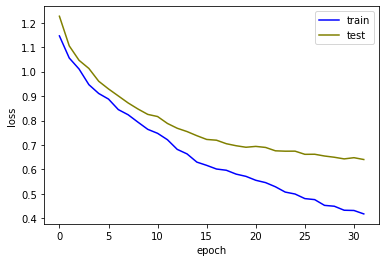


Fold 2
-----------------Epoch = 1-----------------
[epoch 1] loss: 1.143 elapsed time 105.748
1.1995034970735248
-----------------Epoch = 2-----------------
[epoch 2] loss: 1.085 elapsed time 105.598
1.127533285241378
-----------------Epoch = 3-----------------
[epoch 3] loss: 1.016 elapsed time 105.344
1.0678521049650092
-----------------Epoch = 4-----------------
[epoch 4] loss: 0.958 elapsed time 105.149
1.0237177139834355
-----------------Epoch = 5-----------------
[epoch 5] loss: 0.902 elapsed time 105.863
0.9606991661222357
-----------------Epoch = 6-----------------
[epoch 6] loss: 0.872 elapsed time 105.409
0.9189323688808241
-----------------Epoch = 7-----------------
[epoch 7] loss: 0.832 elapsed time 105.524
0.887482646264528
-----------------Epoch = 8-----------------
[epoch 8] loss: 0.775 elapsed time 105.156
0.8420098016136571
-----------------Epoch = 9-----------------
[epoch 9] loss: 0.743 elapsed time 105.721
0.8126409524365475
-----------------Epoch = 10-------------

In [ ]:
if __name__ == "__main__":
    main()